### V9: Fine-Tune DeBERTa-V3-Small 
- Train Data
- Down Sampling 'O' Label 0.30
- External Dataset 
- Evaluation Metric F-Beta5
- Cross Validation
- Max Length 1024
- No Stride

Trained on Kaggle with GPU T4 x2

Inference
- No Truncation
- No Stride

Leaderboard 
- Public Score: 0.947
- Private Score: 0.942

In [40]:
import gc
import json
import numpy as np
import os
import pandas as pd
import torch

from datasets import Dataset
from pathlib import Path
from scipy.special import softmax
from transformers import AutoTokenizer
from transformers import DataCollatorForTokenClassification
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer

In [62]:
class Setting:
    seed = 42
    
    # data
    data = './data/pii-detection-removal-from-educational-data/test.json'
    
    # model
    model_final = './model/v9/final'
    max_length = 256
    non_pii_label_threshold = 0.98
    
    # hyperparameter
    batch_size = 1

In [63]:
def clean_memory(): 
    gc.collect() 
    torch.cuda.empty_cache()

In [64]:
np.random.seed(Setting.seed)
torch.manual_seed(Setting.seed)

In [65]:
df = pd.read_json(Setting.data)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   document             10 non-null     int64 
 1   full_text            10 non-null     object
 2   tokens               10 non-null     object
 3   trailing_whitespace  10 non-null     object
dtypes: int64(1), object(3)
memory usage: 448.0+ bytes


In [66]:
df = df[['document', 'tokens']]
ds = Dataset.from_pandas(df)
ds

Dataset({
    features: ['document', 'tokens'],
    num_rows: 10
})

In [67]:
def tokenize(examples, tokenizer, max_length):
    tokenized_inputs = tokenizer(examples["tokens"], 
                                 truncation=False,
                                 max_length=max_length,                                  
                                 is_split_into_words=True)
    token_maps = []
    for i, token in enumerate(examples[f"tokens"]):
        # map tokens to their respective word.
        word_ids = tokenized_inputs.word_ids(batch_index=i)         
        previous_word_idx = None
        label_ids = []
        token_map_ids = []
        for word_idx in word_ids:  
            if word_idx is None:
                # set the special tokens to -1
                token_map_ids.append(-1)
            elif word_idx != previous_word_idx:
                # only label the first token of a given word
                token_map_ids.append(word_idx)
            else:
                # set other tokens to -1
                token_map_ids.append(-1)
            previous_word_idx = word_idx
        token_maps.append(token_map_ids)
    tokenized_inputs["token_maps"] = token_maps
    return tokenized_inputs

In [68]:
tokenizer = AutoTokenizer.from_pretrained(Setting.model_final)

ds = ds.map(tokenize, 
            fn_kwargs={
              "tokenizer": tokenizer, 
              "max_length": Setting.max_length},
            batched=True)
ds

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Dataset({
    features: ['document', 'tokens', 'input_ids', 'token_type_ids', 'attention_mask', 'token_maps'],
    num_rows: 10
})

In [26]:
clean_memory()

In [10]:
model = AutoModelForTokenClassification.from_pretrained(Setting.model_final)
collator = DataCollatorForTokenClassification(tokenizer)
args = TrainingArguments(
    ".", 
    per_device_eval_batch_size=Setting.batch_size, 
    report_to="none",
)
trainer = Trainer(
    model=model, 
    args=args, 
    data_collator=collator, 
    tokenizer=tokenizer,
)

D:\program\anaconda\envs\fws-dell\lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [11]:
predictions = trainer.predict(ds).predictions
predictions_score = softmax(predictions, axis=-1)

del model, trainer, tokenizer, predictions
clean_memory()

In [12]:
config = json.load(open(Path(Setting.model_final) / "config.json"))
id2label = config["id2label"]

preds_final = []
predicted_labels = predictions_score.argmax(-1)
predicted_pii_labels = predictions_score[:,:,:12].argmax(-1)
non_pii_labels_score = predictions_score[:,:,12]
# take from predicted_pii_labels if non_pii_labels_score less than non_pii_label_threshold 
preds_final.append(np.where(non_pii_labels_score < Setting.non_pii_label_threshold, predicted_pii_labels, predicted_labels))

In [13]:
pairs = []
document, token, label, token_str = [], [], [], []
for pred, input_id, token_map, tokens, doc in zip(preds_final[0], ds["input_ids"], ds["token_maps"], ds["tokens"], ds["document"]):
    token_length = max(token_map)
    for idx in range(len(pred)):
        label_pred = id2label[str(pred[idx])]
        token_id = token_map[idx]
        
        if token_map[idx] == -1 or label_pred == 'O':
            if token_id == token_length:
                break
            continue
    
        pair=(doc, token_id)
        if pair not in pairs:
            document.append(doc)
            token.append(token_id)
            label.append(label_pred)
            token_str.append(tokens[token_id])
            pairs.append(pair)
            
        if token_id == token_length:
            break

In [14]:
df = pd.DataFrame({
    "document": document,
    "token": token,
    "label": label,
    "token_str": token_str
})
df["row_id"] = list(range(len(df)))
display(df.head(100))

,document,token,label,token_str,row_id
0,7,9,B-NAME_STUDENT,Nathalie,0
1,7,10,I-NAME_STUDENT,Sylla,1
2,7,482,B-NAME_STUDENT,Nathalie,2
3,7,483,I-NAME_STUDENT,Sylla,3
4,7,741,B-NAME_STUDENT,Nathalie,4
5,7,742,I-NAME_STUDENT,Sylla,5
6,10,0,B-NAME_STUDENT,Diego,6
7,10,1,I-NAME_STUDENT,Estrada,7
8,10,464,B-NAME_STUDENT,Diego,8
9,10,465,I-NAME_STUDENT,Estrada,9


In [15]:
df[["row_id", "document", "token", "label"]].to_csv("submission.csv", index=False)

In [16]:
df.to_csv("submission1.csv", index=False)

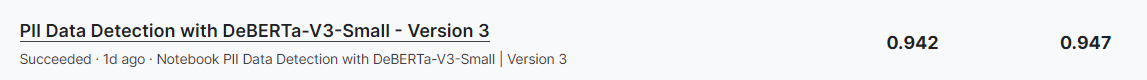